# Dataset Preparation

In [111]:
import urllib.request
import zipfile
import pandas as pd
import numpy as np
import pickle
import os
from tqdm.notebook import tqdm
from random import shuffle
import torch
from torch.utils.data import Dataset

class WeatherJenaDataset(Dataset):
  MEAN = [ 9.88656343e+02,  9.10820659e+00,  2.83194958e+02,  4.59960541e+00,
    7.59060084e+01,  1.33550981e+01,  9.35695962e+00,  3.99805597e+00,
    5.91355033e+00,  9.46637099e+00,  1.21699436e+03, -5.94181630e-01,
    -3.91512714e-01, -9.62158759e-01, -7.09400721e-01, -5.43022767e-05,
    -7.24215306e-05,  5.28237873e-02, -1.62425716e-02]
  STD = [ 8.29746565,  8.65494994,  8.72474584,  6.97227477, 16.55533649,
      7.69473767,  4.20825963,  4.8177406 ,  2.67125215,  4.26005455,
      40.95770444,  2.0129306 ,  1.56150746,  3.12732207,  2.61966312,
      0.70709063,  0.70713733,  0.70062267,  0.71140285]

  def download_dataset(self, root, download):
    path = os.path.join(*[root, 'data.pkl'])
    if not os.path.exists(path) and download:
      # download dataset and import with pandas
      url='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip'
      print('Downloading dataset...')
      filehandle, _ = urllib.request.urlretrieve(url)
      zip_file_object = zipfile.ZipFile(filehandle, 'r')
      first_file = zip_file_object.namelist()[0]
      df = pd.read_csv(zip_file_object.open(first_file, 'r'))
      df = self.prepare_dataset(df)
      os.makedirs(root, exist_ok=True)
      pd.to_pickle(df, path)
      print('Download complete!')
    else:
      assert os.path.exists(path)
      df = pd.read_pickle(path)
      print('Files already downloaded and verified')
    return df

  def prepare_dataset(self, df):
    # subsample
    print(df.shape, self.__dir__())
    df = df.iloc[5::self.subsample_rate].copy()
    date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

    # decompose wind speed
    wv = df['wv (m/s)']
    bad_wv = wv == -9999.0
    wv[bad_wv] = 0.0
    max_wv = df['max. wv (m/s)']
    bad_max_wv = max_wv == -9999.0
    max_wv[bad_max_wv] = 0.0
    # df['wv (m/s)'].min()
    wv = df.pop('wv (m/s)')
    max_wv = df.pop('max. wv (m/s)')
    wd_rad = df.pop('wd (deg)')*np.pi / 180
    df['Wx'] = wv*np.cos(wd_rad)
    df['Wy'] = wv*np.sin(wd_rad)
    df['max Wx'] = max_wv*np.cos(wd_rad)
    df['max Wy'] = max_wv*np.sin(wd_rad)

    # <-------------------------->
    # decompose day/year signal
    timestamp_s = date_time.map(pd.Timestamp.timestamp)
    day_coeff = 2 * np.pi / 24*60*60
    year_coeff = day_coeff * 365
    df['Day sin'] = np.sin(timestamp_s * day_coeff)
    df['Day cos'] = np.cos(timestamp_s * day_coeff)
    df['Year sin'] = np.sin(timestamp_s * year_coeff)
    df['Year cos'] = np.cos(timestamp_s * year_coeff)

    return df

  def split_dataset(self, df, train):
    n = len(df)
    if train:
      return df[0:int(n*0.7)]
    else:
      return df[int(n*0.7):]

  def __init__(self, root, input_width=12, label_shift=2, train=True, download=True, subsample_rate=6):
    super().__init__()
    self.subsample_rate = subsample_rate
    self.label_shift = label_shift
    self.input_width = input_width
    self.ds = self.split_dataset(self.download_dataset(root, download), train)

  def __len__(self):
    return len(self.ds) - self.input_width - self.label_shift

  def __getitem__(self, idx):
    x = self.ds.iloc[idx:idx+self.input_width].values
    y = self.ds.iloc[idx+self.input_width+self.label_shift]['T (degC)'].astype('float32')
    # print(self.ds)
    x = torch.tensor((x - np.array(self.MEAN)) / np.array(self.STD)).float()
    return x, y

In [112]:
train_ds = WeatherJenaDataset('data')

Files already downloaded and verified


In [113]:
print(train_ds.ds.shape)

(49063, 19)


In [114]:
train_ds.ds.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,-0.204862,-0.046168,-0.614587,-0.138503,-0.000245,1.0,-0.072108,0.997397
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,-0.245971,-0.044701,-0.619848,-0.112645,-0.000204,1.0,-0.116999,0.993132
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576,-0.000163,1.0,-0.099698,0.995018
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,-0.050000,-0.086603,-0.190000,-0.329090,-0.000122,1.0,-0.082367,0.996602
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,-0.368202,0.156292,-0.810044,0.343843,-0.000081,1.0,-0.065011,0.997885


In [115]:
from torch.utils.data import DataLoader

train_ds = WeatherJenaDataset('data')
test_ds  = WeatherJenaDataset('data', train=False)

BATCH_SIZE = 32

train_dl = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, num_workers=0, drop_last=True, shuffle=True)
test_dl  = DataLoader(dataset=test_ds, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Text(0.5, 0, 'Timestep')

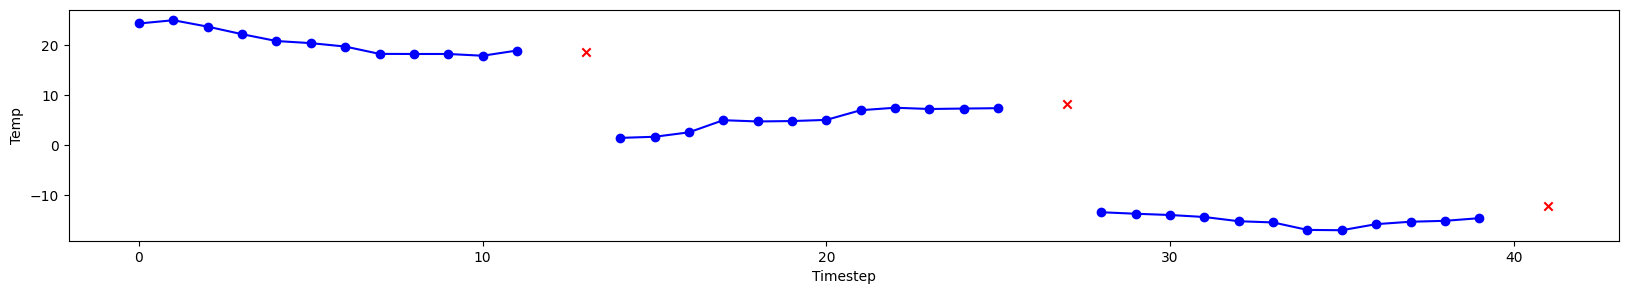

In [116]:
import matplotlib.pyplot as plt

(x, y) = next(iter(train_dl))
plt.figure(figsize=(20,3))
for i in range(len(x[::12])):
  plt.plot(np.arange(len(x[i])) + i * 14, x[i][:, 1]*train_ds.STD[1] + train_ds.MEAN[1], c='blue', marker='o')
  plt.scatter([13 + i * 14], [y[i]], color='red', marker='x')

plt.ylabel('Temp')
plt.xlabel('Timestep')

# Model Definition

In [117]:
import torch
from torch import nn

class WeatherLSTM(nn.Module):
  def __init__(self, num_features_in: int, hidden_dim: int, num_features_out: int):
    super().__init__()
    self.hidden_dim = hidden_dim

    self.lstm = nn.LSTM(num_features_in, hidden_dim, batch_first=True)
    self.head = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, num_features_out))

  def forward(self, X: torch.Tensor):
    # compute the forward pass
    out, (hn, cn) = self.lstm(X)
    # The network's head is basically a regressor based on latent variables extracted by the LSTM
    # In the last hidden layer.
    output = self.head(hn[-1]).view(1, -1)[0]
    return output

# Training Loop

In [118]:
%pip install --upgrade jupyter ipywidgets
# Restart kernel if 'Missing IProgress' error arises in next blocks

91810.85s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 25.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [119]:
def evaluation(net: nn.Module, data_loader: torch.utils.data.DataLoader, device: torch.device):
  err = 0
  total = 0

  with torch.no_grad():
    for x, y in tqdm(data_loader, desc='TEST'):
      x, y = x.to(device), y.to(device)
      y_pred = net(x)
      err += (y - y_pred).abs().sum()
      total += y_pred.size(0)

  return err/total

In [ ]:
from torch.optim import SGD

num_features_in = 19
num_features_out= 1
num_hidden      = 20
num_epochs      = 3
learning_rate   = 0.005

if torch.backends.mps.is_available(): device = torch.device("mps")
elif torch.cuda.is_available(): device = torch.device("cuda:0")
else: assert False, "Cannot find neither Apple Silicon nor NVIDIA GPU"

model = WeatherLSTM(num_features_in=num_features_in, hidden_dim=num_hidden, num_features_out=num_features_out).to(device)

# choose the loss function
loss_fn = nn.MSELoss()  # Suitable for regression tasks like this one
opt = SGD(model.parameters(), lr=learning_rate)

train_err = evaluation(model, train_dl, device)
test_err = evaluation(model, test_dl, device)

print(f'Epoch {0} - Train error {train_err:.3f}\tTest error {test_err:.3f}')
for e in range(num_epochs):
  model.train()
  for i, (x, y) in tqdm(enumerate(train_dl), total=len(train_dl), desc=f'TRAIN epoch {e+1}/{num_epochs}'):
    x, y = x.to(device), y.to(device)

    opt.zero_grad()
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    loss.backward()
    opt.step()

  train_err = evaluation(model, train_dl, device)
  test_err = evaluation(model, test_dl, device)

  print(f'Epoch {e+1:03d} - Train error {train_err:.3f}\tTest error {test_err:.3f}')


TEST:   0%|          | 0/1532 [00:00<?, ?it/s]

TEST:   0%|          | 0/657 [00:00<?, ?it/s]

Epoch 0 - Train error 10.442	Test error 10.673


TRAIN epoch 1/3:   0%|          | 0/1532 [00:00<?, ?it/s]

TEST:   0%|          | 0/1532 [00:00<?, ?it/s]

TEST:   0%|          | 0/657 [00:00<?, ?it/s]

Epoch 001 - Train error 1.526	Test error 1.597


TRAIN epoch 2/3:   0%|          | 0/1532 [00:00<?, ?it/s]

TEST:   0%|          | 0/1532 [00:00<?, ?it/s]

TEST:   0%|          | 0/657 [00:00<?, ?it/s]

Epoch 002 - Train error 1.313	Test error 1.360


TRAIN epoch 3/3:   0%|          | 0/1532 [00:00<?, ?it/s]

TEST:   0%|          | 0/1532 [00:00<?, ?it/s]

TEST:   0%|          | 0/657 [00:00<?, ?it/s]

Epoch 003 - Train error 1.275	Test error 1.310


# Inspect Results

tensor([23.1368, 21.9471, 22.9886, 19.1574, 18.7376, 19.3152, 17.0848, 15.3572,
        15.6110, 15.1256, 14.0436, 14.6031, 13.7459, 13.3104, 13.2077, 13.3401,
        13.3903, 14.3142, 15.9427, 18.1729, 20.9521, 24.2246, 23.8097, 23.6141,
        23.8372, 24.0652, 24.2416, 23.9037, 22.1617, 21.6098, 18.7690, 16.6617])


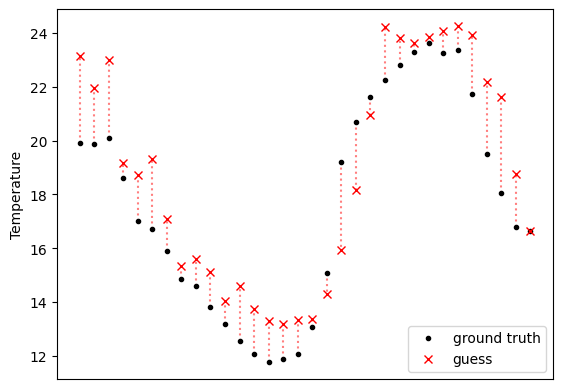

In [121]:
data = next(iter(test_dl))
y = data[1]
y_pred = model(data[0].to(device)).cpu().detach()
print(y_pred)
y, y_pred = y[:32], y_pred[:32]
for i, (yi, yi_pred) in enumerate(zip(y, y_pred)):
  plt.plot([i, i], [yi, yi_pred], color='red', alpha=.5, ls=":")
plt.plot(np.arange(len(y)), y, marker='.', lw=0, color='k', label='ground truth')
plt.plot(np.arange(len(y)), y_pred, marker='x', lw=0, color='red', label='guess')
plt.xticks([])
plt.ylabel('Temperature')
plt.legend(loc='lower right')